In [4]:
# HIDDEN
from datascience import *
%matplotlib inline
import matplotlib.pyplot as plots
plots.style.use('fivethirtyeight')

##Further Generalization: New Test Statistics

Thus far, we have been looking at entire distributions, whether the variable is categorical, such as employment status, or quantitative, such as age. When we analyze quantitative variables, we can summarize the distributions by using measures such as the median and the average. These measures can be useful as test statistics – sometimes, working with them can be more efficient than working with the whole distribution. We will now generalize our methods of testing so that we can replace the total variation distance between distributions by other test statistics of our choice.

As part of the survey we have been studying, the sampled people were asked to rate their satisfaction with their spouse or partner. One of the questions they answered was, "Every relationship has its ups and downs. Taking all things together, how satisfied are you with your relationship with your spouse or partner?"

The question was in a multiple choice format, with the following possible answers:

- 1: very satisfied
- 2: somewhat satisfied
- 3: neither satisfied nor dissatisfied
- 4: somewhat dissatisfied
- 5: very dissatisfied

The answers given by the sampled people are in the column ``rel_rating`` of the table ``couples``. More than 63% of the sampled people gave their satisfaction the highest possible rating:

In [8]:
columns = ['mar_status', 'gender', 'rel_rating', 'age']
couples = Table.read_table('married_couples.csv').select(columns)

def describe(column, descriptions):
    """Relabel a column of codes and add a column of descriptions"""
    code = column + '_code'
    couples.relabel(column, code)
    couples[column] = np.choose(couples[code]-1, descriptions)
    
describe('mar_status', ['married', 'partner'])
describe('gender', ['male', 'female'])
describe('rel_rating', [
    'very satisfied', 
    'somewhat satisfied', 
    'neither satisfied nor dissatisfied', 
    'somewhat dissatisfied', 
    'very dissatisfied', 
])
couples['count'] = 1
couples

mar_status_code,gender_code,rel_rating_code,age,mar_status,gender,rel_rating,count
1,1,1,51,married,male,very satisfied,1
1,2,1,53,married,female,very satisfied,1
1,1,1,57,married,male,very satisfied,1
1,2,1,57,married,female,very satisfied,1
1,1,1,60,married,male,very satisfied,1
1,2,1,57,married,female,very satisfied,1
1,1,1,62,married,male,very satisfied,1
1,2,1,59,married,female,very satisfied,1
1,1,2,53,married,male,somewhat satisfied,1
1,2,2,61,married,female,somewhat satisfied,1


In [10]:
couples.where('rel_rating', 'very satisfied').num_rows/couples.num_rows

0.6353965183752418

Let us examine whether this rating is related to age. Perhaps older people are more appreciative of their relationships, or more frustrated; or perhaps high satisfaction with the spouse or partner has nothing to do with age. As a first step, here are the histograms of the ages of sampled people who gave the highest rating, and those who did not. 

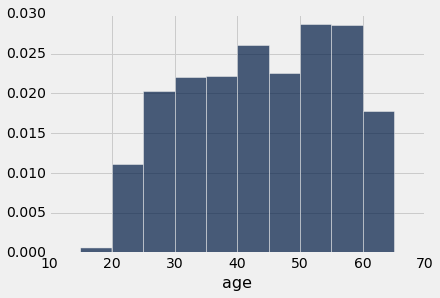

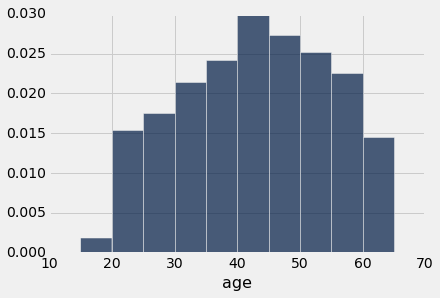

In [11]:
# Compare ages of those who rate satisfaction highly and those who don't

couples['high_rating'] = couples['rel_rating'] == 'very satisfied'

for condition in [True, False]:
    mrr = couples.where('high_rating', condition).select(['age'])
    mrr.hist(bins=np.arange(15,71,5),normed=True)

The two distributions are different, but they are also similar in many ways. This raises the question of how the two distributions compare in the U.S. population.

To answer this, we start by setting up null and alternative hypotheses.

**Null hypothesis.** Among married and cohabitating people in the United States, the distribution of ages of those who give the highest satisfaction rating is the same as the distribution of ages who do not. The difference in the sample is due to chance.

**Alternative hypothesis.** Among married and cohabitating people in the United States, the distribution of ages of those who give the highest satisfaction rating is different from the distribution of ages who do not.

Let us see if we can answer the question by just comparing the medians of the two distributions in the sample. As our test statistic, we will measure how far apart the two medians are.

Formally, the **test statistic** will be the absolute difference between the medians of the ages of the two groups.

In [12]:
np.median(couples.where('high_rating', True)['age'])

44.0

In [13]:
np.median(couples.where('high_rating', False)['age'])

43.0

The median age of those who gave the highest rating is one year more than the median of those who did not. The observed value of our test statistic is therefore 1.

To see how this statistic could vary under the null hypothesis, we will perform a permutation test. The test will involve repeatedly generating permuted samples of ages of the two groups, and calculating the test statistic for each of those samples. So it is useful to define a function that computes the test statistic – the absolute differeence between the medians – for every generated sample.

Like the function ``tvd``, the function ``abs_diff_in_medians`` takes as its arguments the table of data, the name of a column of conditions that come in two categories, and the name of the column of values to be compared. It returns the absolute difference between the median values under the two conditions. By applying this function to the original sample, we can see that it returns the observed value of our test statistic.

In [14]:
def abs_diff_in_medians(t, conditions, values):
    """Compute the difference in the median of values for conditions 1 & 2."""
    a = t.where(conditions, True)[values]
    b = t.where(conditions, False)[values]
    return abs(np.median(a)-np.median(b))

In [15]:
abs_diff_in_medians(couples, 'high_rating', 'age')

1.0

To run the permutation test, we will define a function ``permutation_stat`` that is similar to ``permutation_ tvd`` except that it takes a fourth argument. This argument is the name of a function that computes the test statistic. The code is the same as for ``permutation_tvd`` apart from the number of repetitions and the replacement of ``tvd`` by the generic function ``stat``.

Because ``permutation_test`` takes a function as an argument, it is called a *higher order function*.

In [16]:
def permutation_stat(original, conditions, values, stat):
    repetitions=1600
    test_stats = []

    for i in np.arange(repetitions):
        shuffled = original.sample()
        combined = Table([original[conditions], shuffled[values]], 
                         [conditions, values])
        test_stats.append(stat(combined, conditions, values))

    observation = stat(original, conditions, values)
    p_value = np.count_nonzero(test_stats >= observation) / repetitions
    
    print("Observed value of test statistic:", observation)
    print("Empirical P value:", p_value)
    t = Table([test_stats], ['Empirical dist. of test statistic under null'])
    t.hist(normed=True)

Let us run the permutation test using ``abs_diff_in_medians`` to compute the test statistic. The empirical histogram of the test statistic shows that our observed value of 1 is typical under the null hypothesis. 

Observed value of test statistic: 1.0
Empirical P value: 0.7025


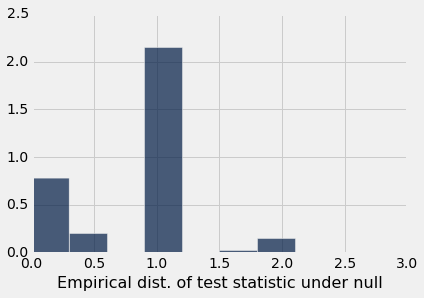

In [17]:
permutation_stat(couples, 'high_rating', 'age', abs_diff_in_medians)

The absolute difference between the medians does not reveal a difference between the two underlying distributions of age. As you can see from the empirical histogram above, the test statistic is rather coarse – it has a small number of likely values. This suggests that it might be more informative to compare means instead of medians.

The functions that we have developed make it easy for us to run the permutation test again, this time with a different test statistic.

The **new test statistic** is the absolute difference between the means.

As before, we will define a function that computes the test statistic based on a sample. Applying this function to the orignial sample shows that the observed means of the two groups differ by about 1.07 years.

In [18]:
def abs_diff_in_means(t, conditions, values):
    """Compute the difference in the mean of values for conditions 1 & 2."""
    a = t.where(conditions, True)[values]
    b = t.where(conditions, False)[values]
    return abs(np.mean(a)-np.mean(b))

In [20]:
abs_diff_in_means(couples, 'high_rating', 'age')

1.0743190048811186